# Importing the needed packages and tools

In [3]:
import warnings
warnings.filterwarnings('ignore')

#data ingestion and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


#modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# Ingesting and exploring the data 

In [4]:
df = pd.read_csv('data.csv')

In [5]:
#Creating a function to explore the df created.
def dataoverview(df):
    print('Number of rows: ', df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nData Features:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [6]:
dataoverview(df)

Number of rows:  10000

Number of features: 14

Data Features:
['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

Missing values: 0

Unique values:
RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
#Looking for duplicates
df.duplicated().sum()

0

In [9]:
#Dropping some of the unncessary columns:
df.drop(columns=['CustomerId', 'Surname', 'RowNumber'],inplace = True)

In [10]:
#Renaming columns for convenience:
df.rename(columns ={'HasCrCard': 'cc', 'IsActiveMember': 'active', 'EstimatedSalary':'salary',\
                   'Exited':'churn', 'NumOfProducts': 'products', 'CreditScore': 'creditscore',\
                   'Geography': 'country', 'Age': 'age',\
                   'Tenure': 'tenure', 'Balance':'balance', 'Gender':'gender'},inplace=True)

In [11]:
#We can use the dataoverview function again. 
dataoverview(df)

Number of rows:  10000

Number of features: 11

Data Features:
['creditscore', 'country', 'gender', 'age', 'tenure', 'balance', 'products', 'cc', 'active', 'salary', 'churn']

Missing values: 0

Unique values:
creditscore     460
country           3
gender            2
age              70
tenure           11
balance        6382
products          4
cc                2
active            2
salary         9999
churn             2
dtype: int64


In [13]:
df.sample(5)

,creditscore,country,gender,age,tenure,balance,products,cc,active,salary,churn
1053,600,Spain,Female,50,6,94684.27,1,1,1,50488.91,0
2549,645,France,Female,36,8,0.00,2,1,1,12096.61,1
3278,640,France,Male,44,7,111833.47,1,1,0,67202.74,0
1705,452,France,Male,35,4,148172.44,1,1,1,4175.68,0
1758,642,Germany,Female,30,5,129753.69,1,1,0,582.53,0


# Let the exploration begin

In [23]:
#Distribution of positive versus negative labels. 
n_class = df.churn.value_counts()[0]
p_class = df.churn.value_counts()[1]
t = df.churn.value_counts().sum()
print(f'{n_class/t*100}% of the labels are negative cases')
print(f'and {p_class/t*100:.2f}% are positive ones')

79.63% of the labels are negative cases
and 20.37% are positive ones


In [24]:
#In this case, we would like to be better at predicting if a customer is likely to churn,
#so, we will focus in predicting properly that 20% or positive class. 

In [25]:
#Numerical versus categorical variables. 
num = ['creditscore', 'age', 'tenure', 'balance', 'products', 'salary', 'churn']
cat = ['country', 'gender', 'cc', 'active']

In [26]:
#Summarize analysis of the df. 
df.describe()

,creditscore,age,tenure,balance,products,cc,active,salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<AxesSubplot:xlabel='creditscore', ylabel='Count'>

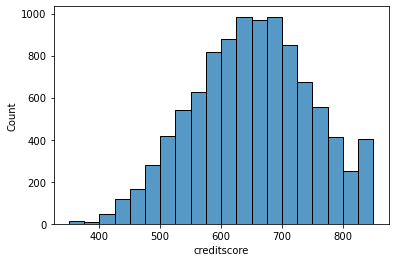

In [27]:
#Seeing the distribution of credit scores.
sns.histplot(x='creditscore', data=df, bins= 20)

<AxesSubplot:xlabel='balance', ylabel='Count'>

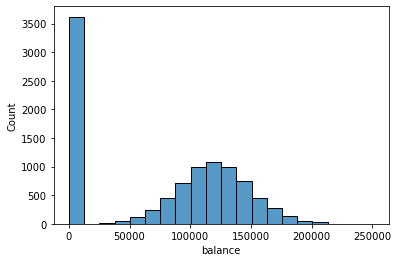

In [19]:
#Distribution of Balance
sns.histplot(x='balance', data=df, bins= 20)

<AxesSubplot:xlabel='age', ylabel='Count'>

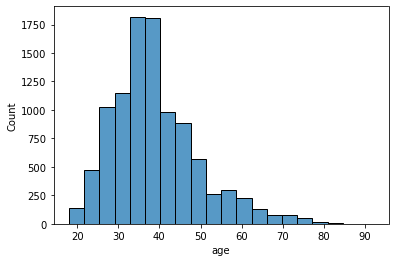

In [427]:
#Distribution of Age
sns.histplot(x='age', data=df, bins= 20)

<AxesSubplot:xlabel='products', ylabel='Count'>

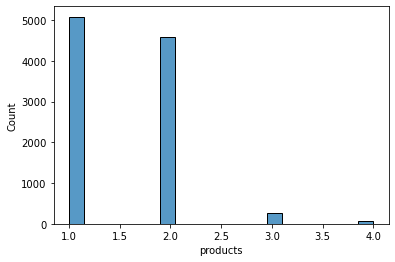

In [20]:
#Distribution of number of products
sns.histplot(x='products', data=df, bins= 20)

<AxesSubplot:xlabel='gender', ylabel='count'>

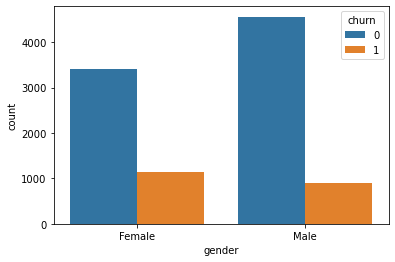

In [37]:
 sns.countplot(x='gender', hue = 'churn',data = df)

In [28]:
#Studying the % of churn based on gender. 
#Male
n_class = df[df.gender=='Male'].churn.value_counts()[0]
p_class = df[df.gender=='Male'].churn.value_counts()[1]
t = df[df.gender=='Male'].churn.value_counts().sum()
print(f'{n_class/t*100}% of the labels are negative cases')
print(f'and {p_class/t*100:.2f}% are positive ones')

83.54407183434121% of the labels are negative cases
and 16.46% are positive ones


In [29]:
#Female
n_class = df[df.gender=='Female'].churn.value_counts()[0]
p_class = df[df.gender=='Female'].churn.value_counts()[1]
t = df[df.gender=='Female'].churn.value_counts().sum()
print(f'{n_class/t*100}% of the labels are negative cases')
print(f'and {p_class/t*100:.2f}% are positive ones')

74.92846136913933% of the labels are negative cases
and 25.07% are positive ones


### We can see that women then to churn in a higher percentage than males.

<AxesSubplot:xlabel='country', ylabel='count'>

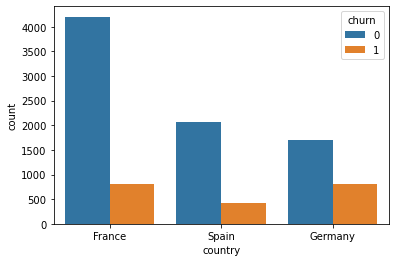

In [117]:
 sns.countplot(x='country', hue = 'churn',data = df)

In [129]:
#Let's evaluate the behavior now based in countries. 
#France
def percentages (df, country):
    n_class = df[df.country==country].churn.value_counts()[0]
    p_class = df[df.country==country].churn.value_counts()[1]
    t = df[df.country==country].churn.value_counts().sum()
    print(f'For {country}, there are: ')
    print(f'{n_class/t*100:.2f}% of the labels are negative cases')
    print(f'and {p_class/t*100:.2f}% are positive ones')

In [130]:
#France

percentages (df,'France')

print('\n')

#Spain
percentages(df,'Spain')

print('\n')

#Germany
percentages(df,'Germany')

For France, there are: 
83.85% of the labels are negative cases
and 16.15% are positive ones


For Spain, there are: 
83.33% of the labels are negative cases
and 16.67% are positive ones


For Germany, there are: 
67.56% of the labels are negative cases
and 32.44% are positive ones


### Germany is the country with the highest rate of customer churn. 

<AxesSubplot:xlabel='products', ylabel='count'>

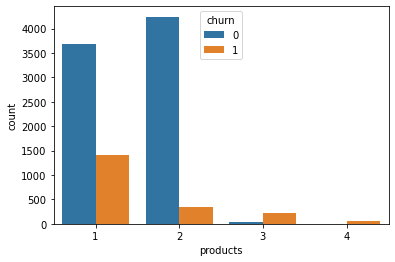

In [132]:
 sns.countplot(x='products', hue = 'churn',data = df)

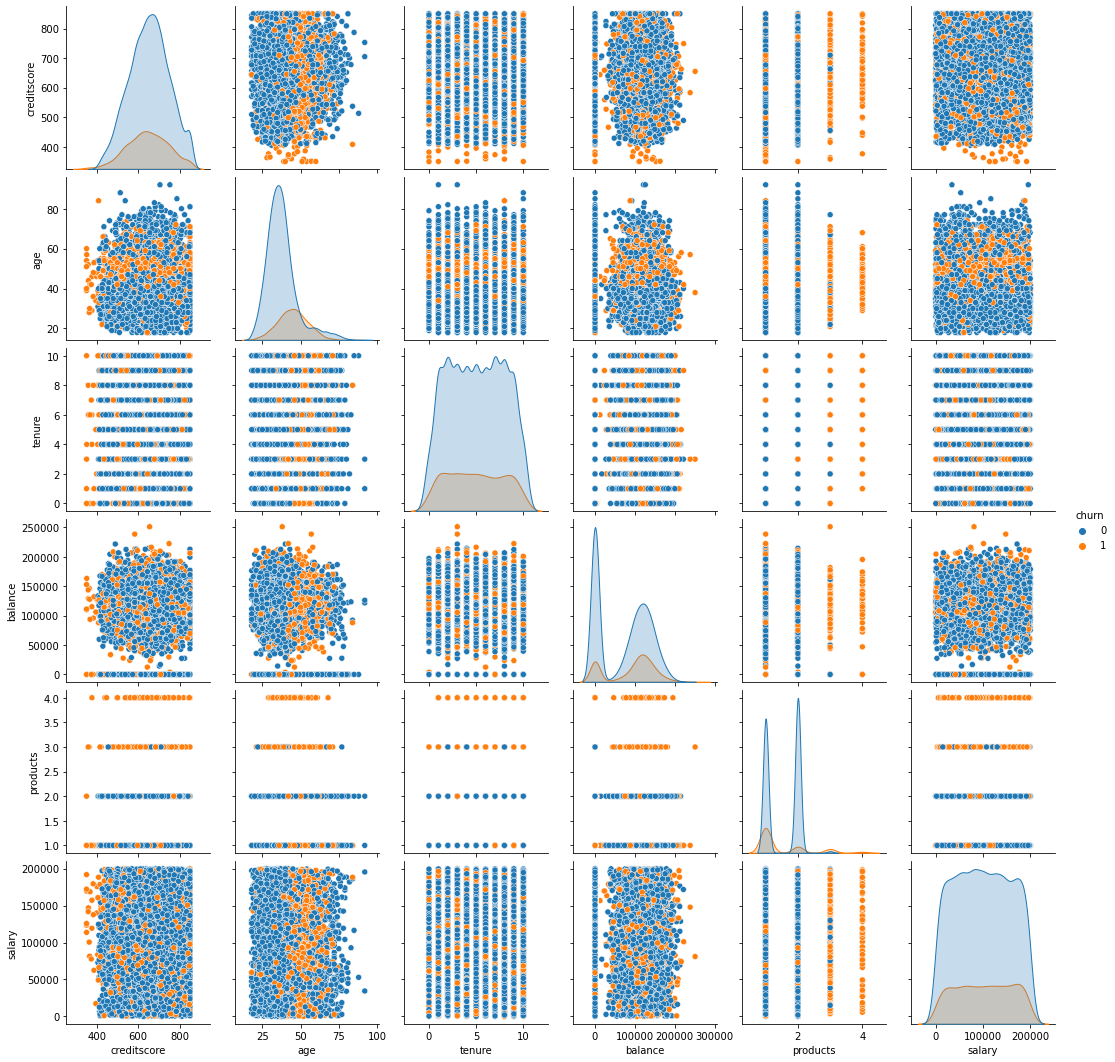

In [95]:
#Pairplot 
sns.pairplot(data=df[num], hue='churn')

In [96]:
#From this data, I don't see a feature that could help me linearly 'separate' the possible outcomes.  

In [34]:
#Turning churn into a category
df.loc[:, 'churn'] = df['churn'].astype('category')

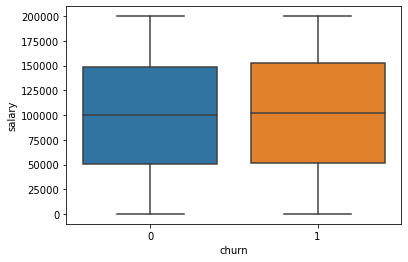

In [35]:
sns.boxplot(x='churn', y='salary', data=df);

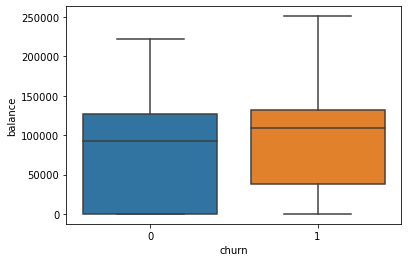

In [36]:
sns.boxplot(x='churn', y='balance', data=df);

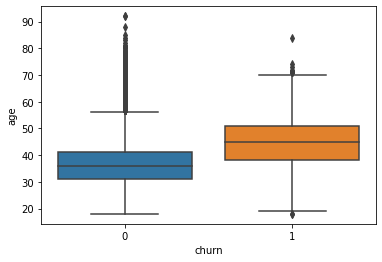

In [38]:
sns.boxplot(x='churn', y='age', data=df);

In [ ]:
#I could see that the older the people, the more likely they are to churn, so, I'll fit a logistic regression
#model with 'Age' as the feature. 


In [187]:
df_train, df_test = train_test_split(df,
                                     test_size=0.2, 
                                     random_state=42)

In [188]:
df_train.head()

,creditscore,country,gender,age,tenure,balance,products,cc,active,salary,churn
9254,686,France,Male,32,6,0.00,2,1,1,179093.26,0
1561,632,Germany,Male,42,4,119624.60,2,1,1,195978.86,0
1670,559,Spain,Male,24,3,114739.92,1,1,0,85891.02,1
6087,561,France,Female,27,9,135637.00,1,1,0,153080.40,1
6669,517,France,Male,56,9,142147.32,1,0,0,39488.04,1


In [189]:
lm_1 = LogisticRegression()

In [190]:
lm_1.fit(df_train[['age']], df_train['churn'])

LogisticRegression()

In [191]:
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(df_test[['age']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['churn']

In [192]:
print(classification_report(df_eval['churn'], df_eval['pred']))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      1607
           1       0.23      0.04      0.07       393

    accuracy                           0.78      2000
   macro avg       0.52      0.50      0.48      2000
weighted avg       0.69      0.78      0.72      2000



In [193]:
confusion_matrix(df_eval['churn'], df_eval['pred'])

array([[1551,   56],
       [ 376,   17]])

In [194]:
#The initial model just catched 17 of the actual positive cases. 

In [195]:
#We see that the precision to predict the class 1 is 0.23. 

# Now, let's use all of the numeric features.

In [202]:
df_train, df_test = train_test_split(df,
                                     test_size=0.2, 
                                     random_state=42)

In [203]:
#We will need to scale our features
scaler = StandardScaler()

In [204]:
y_train = df_train.churn

In [205]:
y_test = df_test.churn

In [206]:
X_train = df_train[['creditscore', 'age', 'tenure','balance', 'products', 'cc', 'salary']]
X_train_scaled = scaler.fit_transform(X_train)

lm2 = LogisticRegression()
lm2.fit(X_train_scaled, y_train)

X_test = df_test[['creditscore', 'age', 'tenure','balance', 'products', 'cc', 'salary']]
X_test.scaled = scaler.transform(X_test)


y_predict = lm2.predict(X_test.scaled) 
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1607
           1       0.32      0.07      0.11       393

    accuracy                           0.79      2000
   macro avg       0.56      0.52      0.50      2000
weighted avg       0.71      0.79      0.73      2000



In [207]:
confusion_matrix(y_test, y_predict)

array([[1552,   55],
       [ 367,   26]])

### Compared to just using 'age' the model improved 0.9 in precision for measuring the positive class and we were able to catch 26 True Positives

# Creating the dummy variables.

In [208]:
#Gender

In [209]:
g_female = pd.get_dummies(df.gender)

In [210]:
g_female.drop(columns= 'Male', inplace=True) #Keeping female as the gender to evaluate. 

In [211]:
#Country

In [214]:
d_country = pd.get_dummies(df.country, drop_first=True)

In [215]:
#Now adding the new columns to a copy of the original dataframe

In [216]:
df2 = df.drop(['gender', 'country'], axis=1)

In [218]:
df2 = pd.concat([df2, g_female, d_country], axis=1)

In [291]:
#Let's run the model again, feeding the new variables

In [918]:
df_train, df_test = train_test_split(df2, test_size=0.2, 
                                     random_state=42)
y_train = df_train.churn
y_test = df_test.churn


In [919]:
X_train = df_train[['creditscore', 'age', 'tenure','balance', 'products', 'cc', 'salary', 'Female', \
                   'Germany', 'Spain']]
X_train_scaled = scaler.fit_transform(X_train)

lm2 = LogisticRegression()
lm2.fit(X_train_scaled, y_train)

X_test = df_test[['creditscore', 'age', 'tenure','balance', 'products', 'cc', 'salary', 'Female', \
                   'Germany', 'Spain']]
X_test_scaled = scaler.transform(X_test)


y_predict = lm2.predict(X_test_scaled) 
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1607
           1       0.50      0.14      0.22       393

    accuracy                           0.80      2000
   macro avg       0.66      0.55      0.55      2000
weighted avg       0.76      0.80      0.76      2000



In [920]:
confusion_matrix(y_test, y_predict)

array([[1552,   55],
       [ 338,   55]])

### Now we have gotten the precision to improve .18 and we have catched 55 of the true positive values

In [265]:
#Let's see the Recall-Precision curve for this model

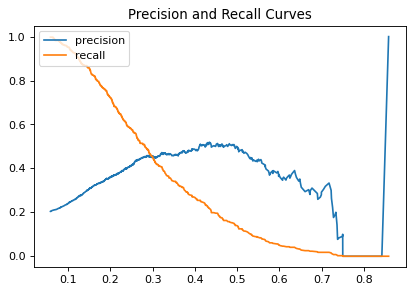

In [295]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm2.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper left')
plt.xlabel('');
plt.title('Precision and Recall Curves');

In [ ]:
#Now, the ROC curve

In [274]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lm2.predict_proba(X_test_scaled)[:,1])

ROC AUC score =  0.7635836219086027


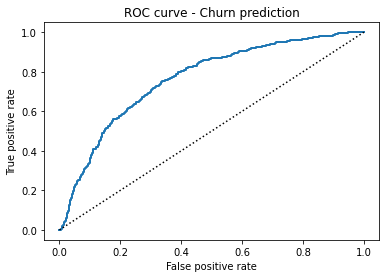

In [351]:
fpr, tpr, thresholds = roc_curve(y_test, lm2.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='black',ls='dotted')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Churn prediction');
print("ROC AUC score = ", roc_auc_score(y_test, lm2.predict_proba(X_test_scaled)[:,1]))

In [923]:
#Using a knn model with all of the features

In [546]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=5)

#X_train_scaled = scaler.fit_transform(X_train)
knn.fit(X_train_scaled, y_train)
y_pred2 = knn.predict(X_test_scaled)

In [547]:
print(classification_report(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1607
           1       0.63      0.41      0.50       393

    accuracy                           0.84      2000
   macro avg       0.75      0.67      0.70      2000
weighted avg       0.82      0.84      0.82      2000

[[1511   96]
 [ 232  161]]


In [916]:
#Money situation = 36k

### Now we have gotten the precision to improve up to 0.63 and we have catched 161 of the true positive values

### Comparing the ROC of the two latest models

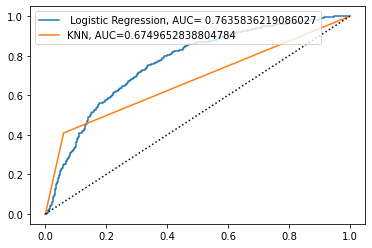

In [286]:
plt.figure(0).clf()

pred = lm2.predict_proba(X_test_scaled)[:,1]
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label=" Logistic Regression, AUC= "+str(auc))

pred = knn.predict(X_test_scaled)
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))
plt.plot([0,1],[0,1],c='black',ls='dotted')
plt.legend(loc='upper left');

In [395]:
#This is the function that I'll use to measure the improvements of my feature engineering.

In [330]:
def newtest(df):
    df_train, df_test = train_test_split(df, test_size=0.2, 
                                     random_state=42)
    y_train = df_train.churn
    y_test = df_test.churn
    df_train.drop(columns='churn', inplace=True)
    df_test.drop(columns = 'churn', inplace=True)
    X_train = df_train
    X_train_scaled = scaler.fit_transform(X_train)

    lm2 = LogisticRegression()
    lm2.fit(X_train_scaled, y_train)

    X_test = df_test
    X_test_scaled = scaler.transform(X_test)


    y_predict = lm2.predict(X_test_scaled) 
    print(classification_report(y_test, y_predict))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_predict))
    print('\n')
    print("Training Score: {:6.5f}%".format(100*lm2.score(X_train_scaled, y_train)))
    print("Test set Score: {:6.5f}%".format(100*lm2.score(X_test_scaled, y_test)))
    
    print('\n Second Model \n')
    
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    y_pred2 = knn.predict(X_test_scaled)
    print(classification_report(y_test, y_pred2))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred2))
    print("Training Score: {:6.5f}%".format(100*knn.score(X_train_scaled, y_train)))
    print("Test set Score: {:6.5f}%".format(100*knn.score(X_test_scaled, y_test)))

In [331]:
newtest(df2)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

Confusion Matrix:
[[1543   64]
 [ 314   79]]


Training Score: 81.13750%
Test set Score: 81.10000%

 Second Model 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.61      0.37      0.46       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000

Confusion Matrix:
[[1514   93]
 [ 247  146]]
Training Score: 87.41250%
Test set Score: 83.00000%


# Creating a Random Forest 

In [384]:
model = RandomForestClassifier(n_estimators=100,
                               max_depth = 7,
                               bootstrap = True,
                               max_features = 'sqrt')

In [385]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, max_features='sqrt')

In [386]:
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

In [392]:
print(classification_report(y_test, (model.predict(X_test))))
print(confusion_matrix(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1607
           1       0.78      0.35      0.48       393

    accuracy                           0.85      2000
   macro avg       0.82      0.66      0.70      2000
weighted avg       0.84      0.85      0.83      2000

[[1568   39]
 [ 256  137]]


In [393]:
#Comparing the performance between training and validation data for the RF. 
print("Training Score: {:6.5f}%".format(100*model.score(X_train, y_train)))
print("Test set Score: {:6.5f}%".format(100*model.score(X_test, y_test)))

Training Score: 86.21250%
Test set Score: 85.25000%


In [387]:
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)

### Graph of the ROC AUC

ROC AUC score =  0.8541812141853944


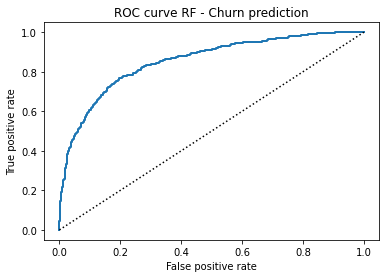

In [388]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='black',ls='dotted')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve RF - Churn prediction');
print("ROC AUC score = ", roc_value)

## Feature Importance from using the features_importance method from RF

In [389]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

,feature,importance
1,age,0.381164
4,products,0.336938
3,balance,0.090201
8,Germany,0.062798
0,creditscore,0.043294
6,salary,0.039100
7,Female,0.020317
2,tenure,0.017457
9,Spain,0.005109
5,cc,0.003622


In [390]:
#This information will be used later, maybe for feature engineering. 

# Now, comparing the ROC AUC of the last three models. 

ValueError: query data dimension must match training data dimension

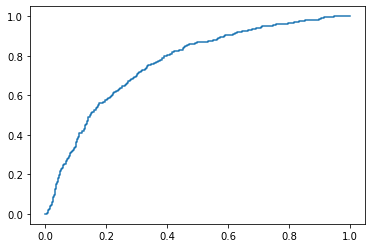

In [922]:
plt.figure(0).clf()

pred = lm2.predict_proba(X_test_scaled)[:,1]
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label=" Logistic Regression, AUC= "+str(auc))

pred = knn.predict(X_test_scaled)
label = y_test
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))
plt.plot([0,1],[0,1],c='black',ls='dotted')

fpr, tpr, thresh = roc_curve(y_test, model.predict_proba(X_test)[:,1])
auc = roc_value
plt.plot(fpr,tpr,label="RF, AUC="+str(auc))
plt.legend(loc='upper left');


# Some more feature engineering. 

In [416]:
df3 = df2.copy() #New dataframe for testing adding some interaction terms. 

In [418]:
#Ratio between balance and salary. 
df3['bal_sal'] = df3['balance']/df3['salary'] #Are they savers or living day by day?

#Also, the ratio of the number of products and the tenure, maybe people with more products and less tenure, 
#may be more likely to leave. 

df3['tenure_prod'] = df3['tenure']/df['products']

In [401]:
#Testing performance improvements, comparing with the previous df2. 

             precision    recall  f1-score   support

           0       0.83      0.96      0.89      1607
           1       0.55      0.20      0.29       393

    accuracy                           0.81      2000
   macro avg       0.69      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000

Confusion Matrix:
[[1543   64]
 [ 314   79]]


Training Score: 81.13750%
Test set Score: 81.10000%

 Second Model 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.61      0.37      0.46       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000

Confusion Matrix:
[[1514   93]
 [ 247  146]]
Training Score: 87.41250%
Test set Score: 83.00000%               df2

In [420]:
#Performance after adding the features. 

In [419]:
newtest(df3)

              precision    recall  f1-score   support

           0       0.84      0.96      0.90      1607
           1       0.60      0.24      0.34       393

    accuracy                           0.82      2000
   macro avg       0.72      0.60      0.62      2000
weighted avg       0.79      0.82      0.79      2000

Confusion Matrix:
[[1544   63]
 [ 298   95]]


Training Score: 81.43750%
Test set Score: 81.95000%

 Second Model 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.61      0.38      0.47       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000

Confusion Matrix:
[[1513   94]
 [ 244  149]]
Training Score: 87.05000%
Test set Score: 83.10000%


In [422]:
#We see some improvements, although really marginal ones.  

In [423]:
df3.head()

,creditscore,age,tenure,balance,products,cc,active,salary,churn,Female,Germany,Spain,bal_sal,tenure_prod
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,0.000000,2.000000
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,1,0.744677,1.000000
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1.401375,2.666667
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.000000,0.500000
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,1,1.587055,2.000000


# Let's see if we can get more out of the age information. 

In [860]:
df4 = df3.copy()

In [861]:
df4['age_by_groups'] = pd.cut(x=df3['age'], bins=[18, 30, 40, 50, 60, 100], labels=['20s', '30s', '40s',\
                                                                                         '50s', '>60'])

In [862]:
df4.head()

,creditscore,age,tenure,balance,products,cc,active,salary,churn,Female,Germany,Spain,bal_sal,tenure_prod,age_by_groups
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,0.000000,2.000000,40s
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,1,0.744677,1.000000,40s
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1.401375,2.666667,40s
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,0.000000,0.500000,30s
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,1,1.587055,2.000000,40s


<AxesSubplot:xlabel='age_by_groups', ylabel='count'>

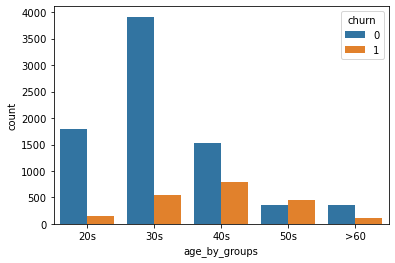

In [863]:
 sns.countplot(x='age_by_groups', hue = 'churn',data = df4)

In [864]:
#Now, create dummies out of those age groups and try the models again. 

In [865]:
df4 = pd.concat([df4, pd.get_dummies(df4.age_by_groups)], axis=1)

In [866]:
df4.drop(columns=['>60', 'age_by_groups'], inplace=True);

In [457]:
#Running the tests for the most basic models. 

In [520]:
newtest(df4)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1607
           1       0.68      0.32      0.44       393

    accuracy                           0.84      2000
   macro avg       0.76      0.64      0.67      2000
weighted avg       0.82      0.84      0.81      2000

Confusion Matrix:
[[1546   61]
 [ 266  127]]


Training Score: 82.63750%
Test set Score: 83.65000%

 Second Model 

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.60      0.37      0.46       393

    accuracy                           0.83      2000
   macro avg       0.73      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000

Confusion Matrix:
[[1507  100]
 [ 246  147]]
Training Score: 87.16250%
Test set Score: 82.70000%


### We can see that binning the ages helped the logistic regression model work catch the TP better. 

# RandomizedSearch for model hyperparameters tuning.



### KNN

In [473]:
from sklearn.model_selection import RandomizedSearchCV

In [924]:
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=[1,3,5,7,8,9,10,11,12,13,14,15,20], weights=weight_options)

In [925]:
#I'll use precision to evaluate the models performance. 

In [926]:
df_train, df_test = train_test_split(df2, test_size=0.2, 
                                     random_state=42)
y_train = df_train.churn
y_test = df_test.churn
df_train.drop(columns='churn', inplace=True)
df_test.drop(columns = 'churn', inplace=True)
X_train = df_train
X_train_scaled = scaler.fit_transform(X_train)
X_test = df_test
X_test_scaled = scaler.transform(X_test)

In [927]:
knn = KNeighborsClassifier()

In [933]:
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='f1', n_iter=10, random_state=3)

In [934]:
rand.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=10,
                   estimator=KNeighborsClassifier(n_neighbors=1,
                                                  weights='distance'),
                   param_distributions={'n_neighbors': [1, 3, 5, 7, 8, 9, 10,
                                                        11, 12, 13, 14, 15,
                                                        20],
                                        'weights': ['uniform', 'distance']},
                   random_state=3, scoring='f1')

In [935]:
print(rand.best_score_)
print(rand.best_params_)
print(rand.best_estimator_)

0.48648674573055395
{'weights': 'distance', 'n_neighbors': 1}
KNeighborsClassifier(n_neighbors=1, weights='distance')


In [704]:
#Trying the Knn model with the best parameters and the last df4.

In [936]:
# Train on training set, and Test on testing set
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')

#X_train_scaled = scaler.fit_transform(X_train)
knn.fit(X_train_scaled, y_train)
y_Bestpred = knn.predict(X_test_scaled)

In [937]:
print(classification_report(y_test, y_Bestpred))
print(confusion_matrix(y_test, y_Bestpred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1607
           1       0.50      0.46      0.48       393

    accuracy                           0.80      2000
   macro avg       0.68      0.67      0.68      2000
weighted avg       0.80      0.80      0.80      2000

[[1422  185]
 [ 211  182]]


#Money evaluation for KNN. 
If someone leaves the bank, we loss 180 from their montly fees. 
If we want to keep someone from leaving, we offer a 50% discount on their fees = -90. 

Reducing fees on the people we think will leave. (185)x90 = 16 E
People that will leave and we didn't do anything = 211x180 = 38 E
People that we prevented for leaving will bring us 90e, 182x90  = -16
Total = 38k E.

# Trying changing the weights in the data for improving LR

In [795]:
df_train, df_test = train_test_split(df4, test_size=0.2, 
                                     random_state=42)
y_train = df_train.churn
y_test = df_test.churn
df_train.drop(columns='churn', inplace=True)
df_test.drop(columns = 'churn', inplace=True)

X_train = df_train
X_train_scaled = scaler.fit_transform(X_train)

lm2 = LogisticRegression(class_weight={1 : 2, 0 : 1})
lm2.fit(X_train_scaled, y_train)

X_test = df_test
X_test_scaled = scaler.transform(X_test)


y_predict = lm2.predict(X_test_scaled) 
print(classification_report(y_test, y_predict))
confusion_matrix(y_test, y_predict)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1607
           1       0.53      0.56      0.55       393

    accuracy                           0.82      2000
   macro avg       0.71      0.72      0.72      2000
weighted avg       0.82      0.82      0.82      2000



array([[1414,  193],
       [ 172,  221]])

#Money evaluation for LR with 1:2 class weight. 
If someone leaves the bank, we loss 180 from their montly fees. 
If we want to keep someone from leaving, we offer a 50% discount on their fees = -90. 

Reducing fees on the people we think will leave. (193)x90 = 17370 E
People that will leave and we didn't do anything = 172x180 = 30960 E
People that we prevented for leaving will bring us 90e, 221x90  = -19890
Total = 28440 E.

In [867]:
#1:3 ratio
df_train, df_test = train_test_split(df4, test_size=0.2, 
                                     random_state=42)
y_train = df_train.churn
y_test = df_test.churn
df_train.drop(columns='churn', inplace=True)
df_test.drop(columns = 'churn', inplace=True)
##Trying something
df_train.drop(columns=['tenure','age'], inplace=True)
df_test.drop(columns = ['tenure','age'], inplace=True)

##End of the trial
X_train = df_train
X_train_scaled = scaler.fit_transform(X_train)

lm2 = LogisticRegression(class_weight={1 : 3, 0 : 1})
lm2.fit(X_train_scaled, y_train)

X_test = df_test
X_test_scaled = scaler.transform(X_test)


y_predict = lm2.predict(X_test_scaled) 
print(classification_report(y_test, y_predict))
confusion_matrix(y_test, y_predict)

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1607
           1       0.44      0.65      0.52       393

    accuracy                           0.77      2000
   macro avg       0.67      0.72      0.69      2000
weighted avg       0.81      0.77      0.78      2000



array([[1286,  321],
       [ 139,  254]])

#Money evaluation for LR with 1:3 class weight. 
If someone leaves the bank, we loss 180 from their montly fees. 
If we want to keep someone from leaving, we offer a 50% discount on their fees = -90. 

Reducing fees on the people we think will leave, but won't. (321)x90 = 28890 E
People that will leave and we didn't do anything = 139x180 = 25020 E
People that we prevented for leaving will bring us 90e, 254x90  = -22860
Total = 31050 E.


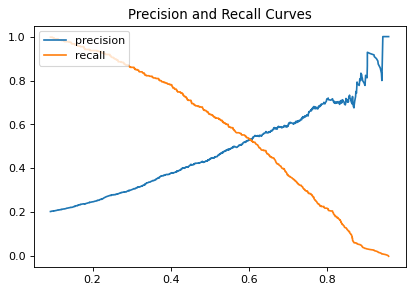

In [868]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm2.predict_proba(X_test_scaled)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='upper left')
plt.xlabel('');
plt.title('Precision and Recall Curves');

Feature: 0, Score: -0.06298
Feature: 1, Score: 0.16794
Feature: 2, Score: -0.01992
Feature: 3, Score: -0.00913
Feature: 4, Score: -0.44787
Feature: 5, Score: 0.01139
Feature: 6, Score: 0.27827
Feature: 7, Score: 0.33503
Feature: 8, Score: 0.03949
Feature: 9, Score: 0.00014
Feature: 10, Score: 0.08977
Feature: 11, Score: -0.64374
Feature: 12, Score: -0.50937
Feature: 13, Score: 0.10201
Feature: 14, Score: 0.34541


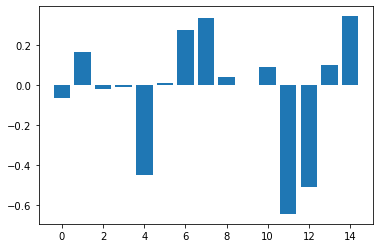

In [869]:
#Seeing the Feature Importance of the Logistic Regression
importance = lm2.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [878]:
testcoe = list(zip(X_train.columns, importance))

In [879]:
testcoe

[('creditscore', -0.06298154594310126),
 ('balance', 0.1679410040370874),
 ('products', -0.0199173896180572),
 ('cc', -0.009128512720230813),
 ('active', -0.447865054947879),
 ('salary', 0.011393065263320101),
 ('Female', 0.278269034505281),
 ('Germany', 0.33502628085939706),
 ('Spain', 0.03949105460002931),
 ('bal_sal', 0.00013928060686029531),
 ('tenure_prod', 0.08976918279426836),
 ('20s', -0.6437383010111801),
 ('30s', -0.5093720860893167),
 ('40s', 0.10200872427345496),
 ('50s', 0.3454083254342362)]

In [880]:
testcoe.sort(key=lambda x: x[1], reverse=True)

In [892]:
testcoe[:4]

[('50s', 0.3454083254342362),
 ('Germany', 0.33502628085939706),
 ('Female', 0.278269034505281),
 ('balance', 0.1679410040370874)]

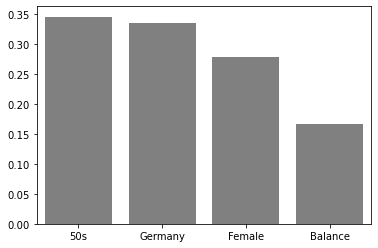

In [938]:
x1 = ['50s', 'Germany', 'Female', 'Balance']
x2 = [0.345, 0.335, 0.278, 0.167]
sns.barplot(x1,x2, color='gray')
plt.show()

In [793]:
#One last try with LogisticRegression. 1:4 Class Ratio
df_train, df_test = train_test_split(df4, test_size=0.2, 
                                     random_state=42)
y_train = df_train.churn
y_test = df_test.churn
df_train.drop(columns='churn', inplace=True)
df_test.drop(columns = 'churn', inplace=True)

X_train = df_train
X_train_scaled = scaler.fit_transform(X_train)

lm2 = LogisticRegression(class_weight={1 : 4, 0 : 1})
lm2.fit(X_train_scaled, y_train)

X_test = df_test
X_test_scaled = scaler.transform(X_test)


y_predict = lm2.predict(X_test_scaled) 
print(classification_report(y_test, y_predict))
confusion_matrix(y_test, y_predict)

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1607
           1       0.40      0.74      0.52       393

    accuracy                           0.73      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.82      0.73      0.75      2000



array([[1167,  440],
       [ 102,  291]])

#Money evaluation for LR with 1:4 class weight. 
If someone leaves the bank, we loss 180 from their montly fees. 
If we want to keep someone from leaving, we offer a 50% discount on their fees = -90. 

Reducing fees on the people we think will leave, but won't. (440)x90 = 39600 E
People that will leave and we didn't do anything = 102x180 = 18360 E
People that we prevented for leaving will bring us 90e, 291x90  = -26190
Total = 31770 E.



# Trying to improve the RF. 

In [801]:
#But first, let's see how it does with df4

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1607
           1       0.82      0.32      0.46       393

    accuracy                           0.85      2000
   macro avg       0.84      0.65      0.69      2000
weighted avg       0.85      0.85      0.83      2000

[[1579   28]
 [ 267  126]]
Training Score: 85.93750%
Test set Score: 85.25000%
ROC AUC score =  0.8574794434653732


,feature,importance
2,products,0.320201
14,50s,0.140555
4,active,0.069624
11,20s,0.068064
12,30s,0.067270
13,40s,0.057971
1,balance,0.054272
7,Germany,0.047389
9,bal_sal,0.043986
0,creditscore,0.036456


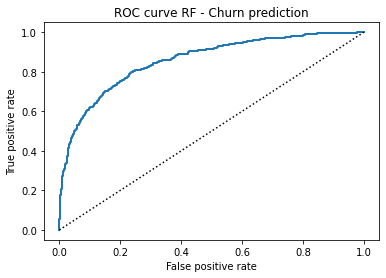

In [889]:
model = RandomForestClassifier(n_estimators=100,
                               max_depth = 7,
                               bootstrap = True,
                               max_features = 'sqrt')
model.fit(X_train, y_train)
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, (model.predict(X_test))))
print(confusion_matrix(y_test, model.predict(X_test)))
#Comparing the performance between training and validation data for the RF. 
print("Training Score: {:6.5f}%".format(100*model.score(X_train, y_train)))
print("Test set Score: {:6.5f}%".format(100*model.score(X_test, y_test)))
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='black',ls='dotted')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve RF - Churn prediction');
print("ROC AUC score = ", roc_value)


fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

#Money evaluation for RF. 
If someone leaves the bank, we loss 180 from their montly fees. 
If we want to keep someone from leaving, we offer a 50% discount on their fees = -90. 

Reducing fees on the people we think will leave, but won't. (36)x90 = 3240 E
People that will leave and we didn't do anything = 242x180 = 43560 E
People that we prevented for leaving will bring us 90e, 151x90  = -13590
Total = 33210 E.

In [805]:
#Now, trying again to optimize. 

In [808]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 40, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [40, 68, 97, 126, 155, 184, 213, 242, 271, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [912]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 7, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 7 folds for each of 100 candidates, totalling 700 fits


RandomizedSearchCV(cv=7, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [40, 68, 97, 126, 155,
                                                         184, 213, 242, 271,
                                                         300]},
                   random_state=42, verbose=2)

In [913]:
rf_random.best_params_

{'n_estimators': 97,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [812]:
#Trying with the new parameters


              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.45      0.57       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.86      0.87      0.85      2000

[[1553   54]
 [ 215  178]]
Training Score: 92.28750%
Test set Score: 86.55000%
ROC AUC score =  0.8588657131411399


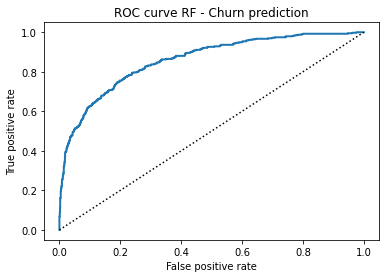

In [914]:
model = RandomForestClassifier(n_estimators= 97,
 min_samples_split= 10,
 min_samples_leaf= 1,
 max_features= 'sqrt',
 max_depth= 110,
 bootstrap= True)
model.fit(X_train, y_train)
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, (model.predict(X_test))))
print(confusion_matrix(y_test, model.predict(X_test)))
#Comparing the performance between training and validation data for the RF. 
print("Training Score: {:6.5f}%".format(100*model.score(X_train, y_train)))
print("Test set Score: {:6.5f}%".format(100*model.score(X_test, y_test)))
# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='black',ls='dotted')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve RF - Churn prediction');
print("ROC AUC score = ", roc_value)




#Money evaluation for RF. 
If someone leaves the bank, we loss 180 from their montly fees. 
If we want to keep someone from leaving, we offer a 50% discount on their fees = -90. 

Reducing fees on the people we think will leave, but won't. (54)x90 = 5130 E
People that will leave and we didn't do anything = 215x180 = 39240 E
People that we prevented for leaving will bring us 90e, 178x90  = -15750
Total = 28620 E.

In [915]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi

,feature,importance
2,products,0.178762
1,balance,0.114043
0,creditscore,0.109698
5,salary,0.109448
9,bal_sal,0.092657
10,tenure_prod,0.076251
14,50s,0.067935
4,active,0.053478
12,30s,0.042686
11,20s,0.040661
